In [228]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt


%matplotlib inline

#for interactive plots
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
pd.__version__

'0.20.3'

In [229]:
# Set path to folder containing Subject data Dictionaries
path = '../Data_dict/' #dictionaries data Mac - (local, much faster)
# path = '/Volumes/RTO/CIS-PD Study/Data_dict/' #Mac
# path = r'W:\CIS-PD Study\Data_dict' #windows repo path

#path to subject scores
pathscores = '../Scores/' #local
# pathscores = r'W:\CIS-PD Study\Scores' #windows repo path
#---------------------------------------------------------------------------------------------------------

In [230]:
def plot_data(acts, activity, trial, sensor, data, start=0, end=100000, plt_ax=None):
#---------------------------------------------------------------------------------------------------------
# Plots requested data
# 
# Inputs: acts - activity dataframe containing all sensor data from one subject
#         activity - desired activity to plot
#         trial - desired trial number to plot
#         sensor - desired sensor (serial number or name of location) to analyze
#         data - desired type of data to analyze (accel, gyro, EMG/ECG)
#         start - starting index, default starts at first point
#         end - ending index, default is 500th data point
#---------------------------------------------------------------------------------------------------------
    rawdata = pd.DataFrame(acts[activity][trial]).loc[data, sensor]#[start:end]
    #reindex time (relative to start)
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    rawdata.plot(figsize=(8,6),ax=plt_ax)
    
#highpass filter data to remove gravity (offset - limb orientation) from accelerometer data from each visit (trial)
#input: Activity dictionary, cutoff freq [Hz], task and sensor location to filter
def HPfilter(act_dict,task,loc,cutoff=0.75,order=4):

    sensor = 'accel'
    for trial in act_dict[task].keys():
        rawdata = act_dict[task][trial][loc][sensor]
        idx = rawdata.index
        idx = idx-idx[0]
        rawdata.index = idx
        x = rawdata.values 
        Fs = np.mean(1/(np.diff(rawdata.index)/1000)) #sampling rate    
        #filter design
        cutoff_norm = cutoff/(0.5*Fs)
        b,a = butter(order,cutoff_norm,btype='highpass',analog=False)
        #filter data
        xfilt = filtfilt(b,a,x,axis=0)
        rawdatafilt = pd.DataFrame(data=xfilt,index=rawdata.index,columns=rawdata.columns)
        act_dict[task][trial][loc][sensor] = rawdatafilt

        
#bandpass filter data (analysis of Tremor)
#input: Activity dictionary, min,max freq [Hz], task and sensor location to filter
def BPfilter(act_dict,task,loc,cutoff_low=3,cutoff_high=8,order=4):
    
    sensor = 'accel'
    for trial in act_dict[task].keys():
        rawdata = act_dict[task][trial][loc][sensor]
        idx = rawdata.index
        idx = idx-idx[0]
        rawdata.index = idx
        x = rawdata.values 
        Fs = np.mean(1/(np.diff(rawdata.index)/1000)) #sampling rate    
        #filter design
        cutoff_low_norm = cutoff_low/(0.5*Fs)
        cutoff_high_norm = cutoff_high/(0.5*Fs)
        b,a = butter(order,[cutoff_low_norm,cutoff_high_norm],btype='bandpass',analog=False)
        #filter data
        xfilt = filtfilt(b,a,x,axis=0)
        rawdatafilt = pd.DataFrame(data=xfilt,index=rawdata.index,columns=rawdata.columns)
        act_dict[task][trial][loc][sensor] = rawdatafilt

In [231]:
#list subjects in db
d = os.listdir(path)
f = [filename[:4] for filename in d if filename.startswith('1')]
print(np.sort(f))

['1004' '1016' '1018' '1019' '1020' '1024' '1029' '1030' '1032' '1038'
 '1044' '1046' '1047' '1049' '1051' '1052']


## Choose subject, task, visit and sensor location

In [232]:
subj = 1004 #choose subj to visualize

In [233]:
#load Pickle file dict
subj_filename = str(subj) + 'dict.pkl'
f = open(os.path.join(path, subj_filename), 'rb')
act_dict = pickle.load(f)
f.close()

In [234]:
#choose task, trials(visits) and sensor location
# side = 'right' #side score to use
side = 'left' #side score to use

# task = 'Motor #8: Typing on a Computer'
# task_scores = 'typing on a computer keyboard' #the task name in the scores file
# task =  'Motor #5: Alternating Hand Movements'
# task_scores = 'alternating left hand movements'
# task_scores = 'alternating right hand movements'

task = 'Motor #4: Finger to Nose'
task_scores = 'finger to nose ' + side + ' hand'
# task = 'Motor #3: Walking while Counting'
# task_scores = 'walking while counting'
# task = 'Motor #6: Sit to Stand'
# task_scores = 'sit to stand'
# task = 'Motor #2: Walking'
# task_scores = 'walking'
# 

trials = list(range(7))

## Scores for current subject

In [235]:
#sanity check
# name = [x for x in mot_scores.columns if 'finger' in x]
# name

In [244]:
#load subject scores
mot_scores = pd.read_excel(os.path.join(pathscores, 'MotorTasks.xls'))
#fix error in original cols labels
mot_scores.columns.values[75] = 'alternating left hand movements tremor right upper limb'
#remove words:(Qxx) and 'rating' from each column for readability
cols= mot_scores.columns
# cols = cols[4:]
cols = cols.tolist()
colsnew = [x.split('(')[0] for x in cols]
colsnew = [x.strip() for x in colsnew] #remove whitspace
colsnew = [x.split('rating')[0] for x in colsnew]
colsnew = [x.strip() for x in colsnew]
colsnew = [x.lower() for x in colsnew] #make all lower case
colsnew = [x.replace('\x97',' ') for x in colsnew] #remove special char

#simplify notation
for i in range(len(colsnew)):
    x = colsnew[i]
    if x.find('finger to nose')>-1:
        colsnew[i] = x.replace(' hand','')
        
    if x.find('alternating')>-1:
        colsnew[i] = x.replace(' hand movements','')

c = dict(zip(cols,colsnew))
mot_scores = mot_scores.rename(index=str, columns=c)

In [237]:
# [x for x in mot_scores.columns if x.find('finger to nose')>-1] #simplify notation

In [238]:
#load subject scores
mot_scores = pd.read_excel(os.path.join(pathscores, 'MotorTasks.xls'))
#remove words:(Qxx) and 'rating' from each column for readability
cols= mot_scores.columns
cols = cols[4:]
cols = cols.tolist()
colsnew = [x.split('(')[0] for x in cols]
colsnew = [x.strip() for x in colsnew] #remove whitspace
colsnew = [x.split('rating')[0] for x in colsnew]
colsnew = [x.strip() for x in colsnew]
colsnew = [x.lower() for x in colsnew] #make all lower case
colsnew = [x.replace('\x97',' ') for x in colsnew]
c = dict(zip(cols,colsnew))
mot_scores = mot_scores.rename(index=str, columns=c)

#change 1 month label to 4 wks for proper sorting
mot_scores.loc[mot_scores['Visit']=='1 Month','Visit']='4 Weeks'

#extract scores for corresponding task, subject and side
subj_score = mot_scores.loc[mot_scores['Subject']==subj,['Subject','Visit',
                            task_scores+ ' ' + 'bradykinesia ' + side + ' upper limb',
                            task_scores+ ' ' + 'tremor ' + side + ' upper limb',
                            task_scores+ ' ' + 'overall score']]
#rename cols
subj_score = subj_score.rename(index=str,
                               columns={subj_score.columns[2]:'Bradykinesia',subj_score.columns[3]:'Tremor', 
                                       subj_score.columns[4]:'overall'})
subj_score.index = range(len(subj_score))
subj_score


,Subject,Visit,Bradykinesia,Tremor,overall
0,1004,2 Weeks: Time 0,1.0,1.0,1.0
1,1004,2 Weeks: Time 30,1.0,1.0,1.0
2,1004,2 Weeks: Time 60,1.0,0.0,1.0
3,1004,2 Weeks: Time 90,1.0,0.0,1.0
4,1004,2 Weeks: Time 120,0.0,0.0,0.0
5,1004,2 Weeks: Time 150,1.0,0.0,1.0
6,1004,4 Weeks,1.0,1.0,1.0


In [9]:
# #extract both sides scores for corresponding task and subject
# subj_score = mot_scores.loc[mot_scores['Subject']==subj,['Subject','Visit',
#                             task_scores+ ' ' + 'bradykinesia right upper limb',
#                             task_scores+ ' ' + 'tremor right upper limb',
#                             task_scores+ ' ' + 'bradykinesia left upper limb',
#                             task_scores+ ' ' + 'tremor left upper limb',
#                             task_scores+ ' ' + 'overall score']]
# subj_score = subj_score.rename(index=str,
#                                columns={subj_score.columns[2]:'Bradykinesia right',subj_score.columns[3]:'Tremor right', 
#                                        subj_score.columns[4]:'Bradykinesia left',subj_score.columns[5]:'Tremor left',
#                                        subj_score.columns[6]:'overall'})


## Histogram of scores for specific task and all subjects 

In [ ]:
#histogram of motor scores from all subjects for current task
S = mot_scores[[            task_scores+ ' ' + 'bradykinesia right upper limb',
                            task_scores+ ' ' + 'tremor right upper limb',
                            task_scores+ ' ' + 'bradykinesia left upper limb',
                            task_scores+ ' ' + 'tremor left upper limb',
                            task_scores+ ' ' + 'overall score']]

S = S.rename(index=str,columns={S.columns[0]:'Bradykinesia right',S.columns[1]:'Tremor right', 
                                       S.columns[2]:'Bradykinesia left',S.columns[3]:'Tremor left',
                                       S.columns[4]:'overall'})
sns.set_context('paper',font_scale=1.5)
ax = S.hist(figsize=(20,20),xlabelsize=12,ylabelsize=12)

# Raw sensors data visualization - single subject
### plot all trials data from either one side or both sides

In [ ]:
# act_dict[task][3] #to test new code of fix error

In [60]:
#filter data
loc1 = 'dorsal_hand_left'
loc2 = 'dorsal_hand_right'
HPfilter(act_dict,task=task,loc=loc1)
HPfilter(act_dict,task=task,loc=loc2)

In [61]:
# BPfilter(act_dict,task=task,loc=loc1)
# BPfilter(act_dict,task=task,loc=loc2)

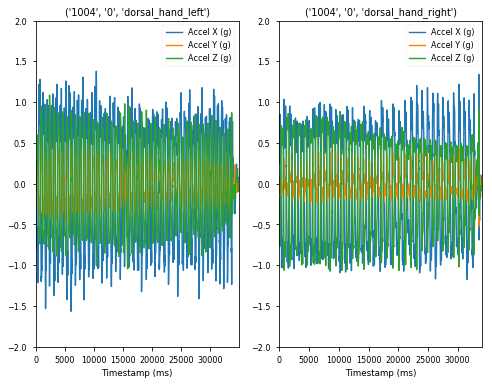

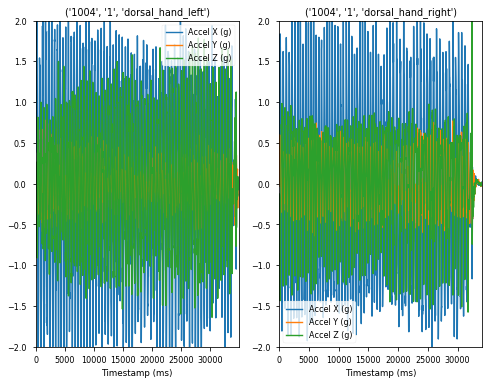

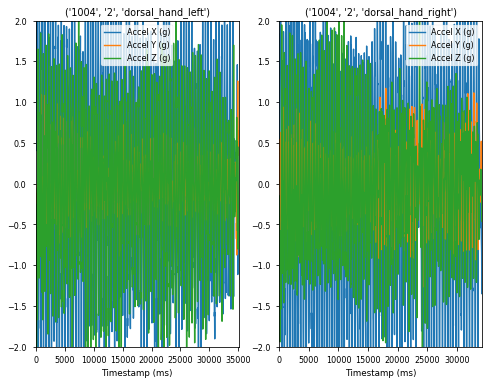

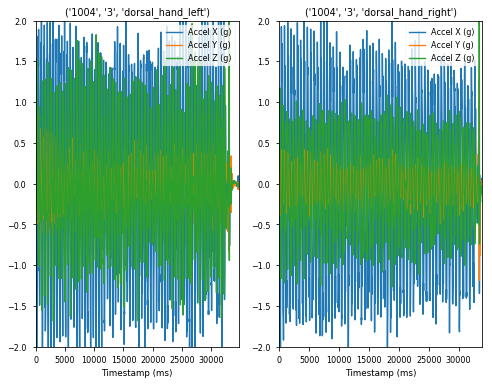

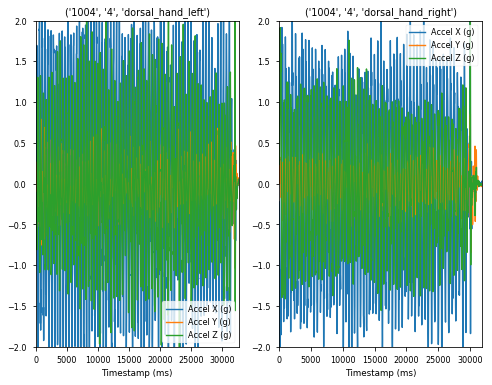

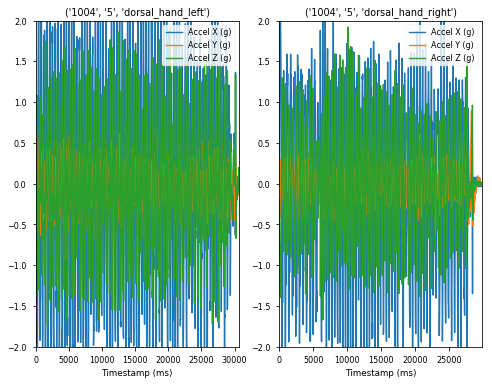

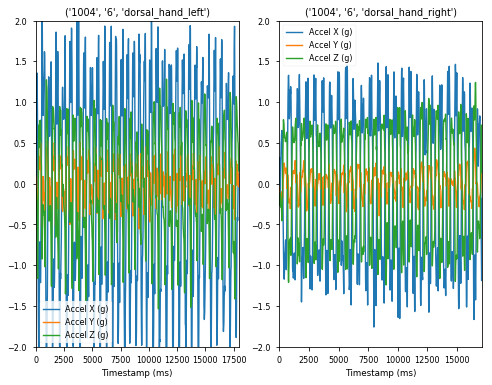

In [62]:
#plot L and R side
trials = act_dict[task].keys() #all available trials
sns.set_context('paper')
p = product([task],trials)
taskslist = list(p)
for t in taskslist:
    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    plot_data(act_dict,t[0],t[1],loc1,'accel',plt_ax=ax1)
    ax1.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc1]))
    ax1.set_ylim([-2,2])
    ax2 = fig.add_subplot(122)
    plot_data(act_dict,t[0],t[1],loc2,'accel',plt_ax=ax2)
    ax2.set_title(tuple([str(subj)])+tuple([str(t[1])])+tuple([loc2]))
    ax2.set_ylim([-2,2])

In [ ]:
#plot one side only
sns.set_context('paper')
p = product([task],trials)
taskslist = list(p)
for t in taskslist:
    plot_data(act_dict,t[0],t[1],loc,'accel')
    plt.title(tuple([str(subj)])+t+tuple([loc]))

# Plot raw data from all subjects for a given task and trial

In [ ]:
#choose task, trials(visits) and sensor location
loc1 = 'dorsal_hand_left'
loc2 = 'dorsal_hand_right'
# loc1 = 'flexor_digitorum_left'
# loc2 = 'flexor_digitorum_right'
trial = 5

In [ ]:
#list subjects in db
d = os.listdir(path)
all_f = [filename[:4] for filename in d if filename.startswith('1')]
print(np.sort(all_f))

In [ ]:
#load Pickle file dict
for subj in all_f:
    subj_filename = str(subj) + 'dict.pkl'
    f = open(os.path.join(path, subj_filename), 'rb')
    act_dict = pickle.load(f)
    f.close()
    #filter data
    HPfilter(act_dict,task=task,loc=loc1)
    HPfilter(act_dict,task=task,loc=loc2)
    BPfilter(act_dict,task=task,loc=loc1)
    BPfilter(act_dict,task=task,loc=loc2)
    
    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    plot_data(act_dict,task,trial,loc1,'accel',plt_ax=ax1)
    ax1.set_title(tuple([str(subj)])+tuple([str(trial)])+tuple([loc1]))
    ax1.set_ylim([-1,1])
    ax2 = fig.add_subplot(122)
    plot_data(act_dict,task,trial,loc2,'accel',plt_ax=ax2)
    ax2.set_title(tuple([str(subj)])+tuple([str(trial)])+tuple([loc2]))
    ax2.set_ylim([-1,1])

# List of activities / sensor locations

In [7]:
sorted(list(act_dict.keys()))

['Heart Rate Variability',
 'MDS-UPDRS #10: Kinetic Hand Tremor',
 'MDS-UPDRS #11: Rest Tremor',
 'MDS-UPDRS #1: Finger Tapping',
 'MDS-UPDRS #2: Hand Movements',
 'MDS-UPDRS #3: Pronation-Supination',
 'MDS-UPDRS #4: Toe Tapping',
 'MDS-UPDRS #5: Leg Agility',
 'MDS-UPDRS #6: Arising from Chair',
 'MDS-UPDRS #7: Gait',
 'MDS-UPDRS #8: Postural Stability',
 'MDS-UPDRS #9: Postural Hand Tremor',
 'Motor #10: Drinking Water',
 'Motor #11: Organizing Folder',
 'Motor #12: Folding Towels',
 'Motor #13: Sitting',
 'Motor #1: Standing',
 'Motor #2: Walking',
 'Motor #3: Walking while Counting',
 'Motor #4: Finger to Nose',
 'Motor #5: Alternating Hand Movements',
 'Motor #6: Sit to Stand',
 'Motor #7: Drawing on Paper',
 'Motor #8: Typing on a Computer',
 'Motor #9: Nuts and Bolts']

In [8]:
sorted(list(act_dict[ 'Motor #2: Walking'][0].keys()))

['anterior_thigh_left',
 'anterior_thigh_right',
 'distal_lateral_shank_left',
 'distal_lateral_shank_right',
 'dorsal_hand_left',
 'dorsal_hand_right',
 'flexor_digitorum_left',
 'flexor_digitorum_right',
 'medial_chest',
 'sacrum']

In [ ]:
#task scores names
